<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/FinanceAI_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- Define the ticker and date range ---
ticker_symbol = "AAPL"
# Define a date range for historical data
end_date = datetime.now()
start_date = end_date - timedelta(days=365*2) # Get data for the last 2 years

print(f"Attempting to download historical data for {ticker_symbol} from {start_date.date()} to {end_date.date()}...\n")

try:
    # --- Download the data ---
    # We request Open, High, Low, Close, Adj Close, Volume
    aapl_data = yf.download(ticker_symbol, start=start_date, end=end_date)

    if aapl_data.empty:
        print(f"Could not download data for {ticker_symbol}. Please check the ticker symbol and date range.")
    else:
        print("Successfully downloaded data.")
        print("\nSample Data (first 5 rows):")
        print(aapl_data.head())

        print("\nSample Data (last 5 rows):")
        print(aapl_data.tail())

        print(f"\nTotal number of data points: {len(aapl_data)}")

        # --- Basic Plot (Optional) ---
        # You can visualize the closing price
        plt.figure(figsize=(12, 6))
        plt.plot(aapl_data['Adj Close'])
        plt.title(f'{ticker_symbol} Historical Adjusted Close Price')
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.grid(True)
        plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure you have an internet connection and that yfinance is correctly installed.")


# --- How to use this data with previous examples ---
# The 'aapl_data' DataFrame contains columns like 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'.
# You would typically use the 'Adj Close' price for historical analysis as it accounts for splits and dividends.
# You would replace the simulated 'Price' column in our previous examples with 'aapl_data['Adj Close']'.

# For example, to calculate Moving Averages on AAPL data:
# aapl_data['Short_MA'] = aapl_data['Adj Close'].rolling(window=5).mean()
# aapl_data['Long_MA'] = aapl_data['Adj Close'].rolling(window=10).mean()
# print("\nAAPL data with Moving Averages:")
# print(aapl_data[['Adj Close', 'Short_MA', 'Long_MA']].tail())

# To use it for the ML example, you would calculate features and the target
# using 'aapl_data['Adj Close']' and then train your model as shown before.

Attempting to download historical data for AAPL from 2023-04-24 to 2025-04-23...

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Successfully downloaded data.

Sample Data (first 5 rows):
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2023-04-24  163.679337  163.946645  162.253711  163.352629  41949600
2023-04-25  162.134918  164.649552  162.095309  163.540739  48714100
2023-04-26  162.125000  163.629828  161.174593  161.431992  45498800
2023-04-27  166.728592  166.877088  163.540739  163.540739  64902300
2023-04-28  167.985901  168.154217  166.203884  166.807795  55209200

Sample Data (last 5 rows):
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-04-15  202.139999  203.509995  199.800003  201.860001  51343900
2025-04-16  194.270004  200.699997  192.369995  198.360001  59732400
2025-04-17  196.

<Figure size 1200x600 with 0 Axes>

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report # Optional: uncomment for evaluation metrics
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time # To simulate delay if needed, not used in this script

# --- 1. Configuration and Parameters ---
ticker_symbol = "AAPL"
start_date = datetime.now() - timedelta(days=365 * 3) # Data for last 3 years
end_date = datetime.now()

# Strategy Parameters
short_window = 20 # Increased window for more data
long_window = 50  # Increased window for more data

# ML Parameters
test_size_split = 0.2 # 20% of data for simulating testing

# Illustrative Risk Management Parameters (Highly Simplified)
initial_capital = 100000.0 # Starting hypothetical capital
max_risk_per_trade_pct = 0.01 # Max 1% of capital per trade
stop_loss_percentage = 0.03 # 3% stop loss below entry price
max_open_positions = 5    # Maximum number of simultaneous hypothetical open trades
min_price_to_trade = 50.0 # Don't trade if price is below this

# --- 2. Download Historical Data ---
print(f"Attempting to download historical data for {ticker_symbol} from {start_date.date()} to {end_date.date()}...")

try:
    # auto_adjust=True means 'Close' column is already adjusted
    aapl_data = yf.download(ticker_symbol, start=start_date, end=end_date, auto_adjust=True)

    if aapl_data.empty:
        print(f"Error: Could not download data for {ticker_symbol}. Exiting.")
        exit() # Exit if data download fails

    print("Successfully downloaded data.")
    print(f"Total data points: {len(aapl_data)}")
    print("Columns available:", aapl_data.columns.tolist()) # Check available columns
    # We expect ['Open', 'High', 'Low', 'Close', 'Volume'] due to auto_adjust=True

except Exception as e:
    print(f"An error occurred during data download: {e}")
    print("Please check your internet connection and the ticker symbol.")
    exit() # Exit on download error


# --- 3. Feature Engineering ---
# Use 'Close' column for all price-based calculations
aapl_data['Price_Change'] = aapl_data['Close'].diff()
aapl_data['Short_MA'] = aapl_data['Close'].rolling(window=short_window).mean()
aapl_data['Long_MA'] = aapl_data['Close'].rolling(window=long_window).mean()
aapl_data['MA_Difference'] = aapl_data['Short_MA'] - aapl_data['Long_MA']
aapl_data['Volume_MA'] = aapl_data['Volume'].rolling(window=short_window).mean() # Add a volume feature

# --- Create Target Variable ---
# Predict if the Close price goes up tomorrow (1) or not (0)
aapl_data['Target'] = (aapl_data['Close'].shift(-1) > aapl_data['Close']).astype(int)

# --- 4. Data Preparation for ML ---
# Define features (X) and target (y)
# Use features that are available *before* the target outcome is known
features = ['Close', 'Price_Change', 'Short_MA', 'Long_MA', 'MA_Difference', 'Volume', 'Volume_MA']

# Drop rows with NaN values created by rolling windows and shift(-1)
# The number of NaNs depends on the largest window size (long_window)
aapl_data_cleaned = aapl_data.dropna().copy() # Use .copy() to avoid SettingWithCopyWarning

if len(aapl_data_cleaned) < 100: # Basic check if enough data remains
    print(f"Error: Not enough data remaining after cleaning ({len(aapl_data_cleaned)}). Adjust date range or windows. Exiting.")
    exit()

X = aapl_data_cleaned[features]
y = aapl_data_cleaned['Target']

# Split data into training and testing sets (simulating out-of-sample testing)
# shuffle=False is crucial for time series data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_split, shuffle=False)

print(f"\nData prepared for ML. Training on {len(X_train)} samples, testing on {len(X_test)} samples.")

# --- 5. Train the ML Model ---
print("\nTraining the ML model...")
model = LogisticRegression(max_iter=1000) # Increased max_iter for potential convergence
model.fit(X_train, y_train)
print("Model training complete.")

# Optional: Evaluate model performance (uncomment imports at top)
# y_pred = model.predict(X_test)
# print("\nML Model Evaluation on Test Set:")
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
# print("Classification Report:")
# print(classification_report(y_test, y_pred))


# --- 6. Generate Trading Signals based on ML Predictions ---
# We will generate signals for the *entire* cleaned dataset to simulate backtesting
# In real trading, you predict on the latest available data.
aapl_data_cleaned['Predicted_Target'] = model.predict(X)

# Generate a simple buy signal if the model predicts the price will go up (1)
# And a simple sell/exit signal if it predicts the price will not go up (0)
# This is a very basic strategy based solely on prediction. Real strategies are more complex.
aapl_data_cleaned['ML_Signal'] = np.where(aapl_data_cleaned['Predicted_Target'] == 1, 1, 0) # Use int 0/1

# Calculate position changes (1 for entry, -1 for exit)
# Fill NaN from diff() with 0 as no change occurred
aapl_data_cleaned['ML_Positions'] = aapl_data_cleaned['ML_Signal'].diff().fillna(0)


# --- 7. Illustrative Backtesting Simulation with Basic Risk Management ---

print("\n--- Starting Illustrative Backtesting Simulation ---")

# Initialize hypothetical account and position tracking
account_balance = initial_capital
current_capital = initial_capital # Capital available for trading (excludes value of open positions)
open_positions_count = 0
hypothetical_open_trades = {} # {trade_id: {'entry_price': price, 'num_shares': shares, 'stop_loss': price, 'take_profit': price}}
trade_counter = 0 # To generate unique trade IDs

# Iterate through the data points chronologically
# Start after the training period to simulate trading on unseen data
# We iterate through the *entire* cleaned data for the backtest visualization
# In a real scenario, you'd use a strict walk-forward testing approach
test_data_start_index = len(X_train) # Start backtest from where training ended

# Iterate through the cleaned DataFrame starting from the first day of the test set
for i in range(test_data_start_index, len(aapl_data_cleaned)):
    date = aapl_data_cleaned.index[i]
    #current_price = aapl_data_cleaned['Close'].iloc[i]

    current_price = aapl_data_cleaned['Close'].iloc[i].item()
    ml_signal_change = aapl_data_cleaned['ML_Positions'].iloc[i] # 1 for buy signal, -1 for sell signal


    # --- Risk Management: Check for Stop Loss/Take Profit Triggers on Open Positions ---
    trades_to_close = []
    for trade_id, trade_info in hypothetical_open_trades.items():
        if current_price <= trade_info['stop_loss']:
            print(f"{date.date()}: Risk Alert: Stop Loss Triggered for {trade_id} (Price: {current_price:.2f}, Stop Loss: {trade_info['stop_loss']:.2f})")
            # Simulate closing position
            profit_loss = (current_price - trade_info['entry_price']) * trade_info['num_shares']
            account_balance += (trade_info['entry_price'] * trade_info['num_shares']) + profit_loss # Return initial investment + P/L
            current_capital += (trade_info['entry_price'] * trade_info['num_shares']) + profit_loss # Capital increases by P/L
            print(f"  - Closed {trade_id}: Realized P/L = {profit_loss:.2f}. New Balance = {account_balance:.2f}")
            trades_to_close.append(trade_id)
        # Add Take Profit check here if implemented
        # elif current_price >= trade_info['take_profit']:
        #    ... simulate closing at take profit ...
        #    trades_to_close.append(trade_id)

    # Remove closed trades
    for trade_id in trades_to_close:
        if trade_id in hypothetical_open_trades:
            del hypothetical_open_trades[trade_id]
            open_positions_count = len(hypothetical_open_trades) # Update count based on actual open trades


    # --- Process New ML Signals ---
    if ml_signal_change == 1: # ML Model generated a Buy signal
        # --- Risk Check 1: Minimum Price ---
        if current_price < min_price_to_trade:
            print(f"{date.date()}: Buy Signal Ignored: Price ({current_price:.2f}) below minimum trade price ({min_price_to_trade:.2f})")
            continue # Skip this signal

        # --- Risk Check 2: Maximum Open Positions ---
        if open_positions_count >= max_open_positions:
            print(f"{date.date()}: Buy Signal Ignored: Max open positions ({max_open_positions}) reached")
            continue # Skip this signal

        # --- Risk Check 3 (Conceptual): Sufficient Capital for Risk ---
        # Calculate how many shares we can buy based on risk per trade
        # Price difference from entry to stop loss is the risk per share
        hypothetical_risk_per_share = current_price * stop_loss_percentage
        if hypothetical_risk_per_share <= 0: # Avoid division by zero or negative risk
             print(f"{date.date()}: Buy Signal Ignored: Invalid risk calculation ({hypothetical_risk_per_share:.4f})")
             continue

        # Maximum shares based on risk per trade
        max_shares_by_risk = (current_capital * max_risk_per_trade_pct) / hypothetical_risk_per_share

        # Also consider how many shares we can buy with available capital
        max_shares_by_capital = current_capital / current_price

        # Buy the minimum of the two to respect both risk and capital constraints
        num_shares_to_buy = min(max_shares_by_risk, max_shares_by_capital)

        if num_shares_to_buy < 1: # Don't buy fractional shares or zero
             print(f"{date.date()}: Buy Signal Ignored: Not enough capital for a single share at calculated risk.")
             continue

        # Round down to full shares
        num_shares_to_buy = int(num_shares_to_buy)

        # --- Execute Buy (Simulated) ---
        trade_counter += 1
        trade_id = f"BUY_{date.strftime('%Y%m%d')}_{trade_counter}"
        entry_price = current_price
        cost = entry_price * num_shares_to_buy
        hypothetical_stop_loss = entry_price * (1 - stop_loss_percentage)
        # hypothetical_take_profit = entry_price * (1 + take_profit_percentage) # If you add take profit

        # Update hypothetical state
        hypothetical_open_trades[trade_id] = {
            'entry_price': entry_price,
            'num_shares': num_shares_to_buy,
            'stop_loss': hypothetical_stop_loss,
            # 'take_profit': hypothetical_take_profit # If you add take profit
        }
        open_positions_count = len(hypothetical_open_trades)
        current_capital -= cost # Capital available decreases by the cost of the trade
        # account_balance doesn't change until position is closed (realized P/L)


        print(f"{date.date()}: --- BUY SIGNAL ---")
        print(f"  - Price: {current_price:.2f}")
        print(f"  - Action: Hypothetically Bought {num_shares_to_buy} shares at {entry_price:.2f}")
        print(f"  - Hypothetical Cost: {cost:.2f}")
        print(f"  - Hypothetical Stop Loss: {hypothetical_stop_loss:.2f}")
        print(f"  - Open Positions: {open_positions_count}. Current Capital: {current_capital:.2f}. Account Balance: {account_balance:.2f}")


    elif ml_signal_change == -1: # ML Model generated a Sell/Exit signal
        # This is simplistic. A real agent needs to decide *which* position to close.
        # For illustration, we'll just simulate closing *one* open position if any exist.
        if open_positions_count > 0:
            # Get the ID of an open trade (e.g., the oldest or most recent - simplistic!)
            trade_to_close_id = list(hypothetical_open_trades.keys())[0] # Just get the first one
            closed_trade = hypothetical_open_trades.pop(trade_to_close_id)
            open_positions_count = len(hypothetical_open_trades)

            entry_price = closed_trade['entry_price']
            num_shares = closed_trade['num_shares']
            profit_loss = (current_price - entry_price) * num_shares # P/L based on current price

            account_balance += (entry_price * num_shares) + profit_loss # Return initial investment + P/L
            current_capital += (entry_price * num_shares) + profit_loss # Capital increases by P/L

            print(f"{date.date()}: --- SELL SIGNAL ---")
            print(f"  - Price: {current_price:.2f}")
            print(f"  - Action: Hypothetically Sold/Exited position {trade_to_close_id}")
            print(f"  - Entry Price: {entry_price:.2f}, Exit Price: {current_price:.2f}, Shares: {num_shares}")
            print(f"  - Realized P/L = {profit_loss:.2f}. New Balance = {account_balance:.2f}")
            print(f"  - Open Positions: {open_positions_count}. Current Capital: {current_capital:.2f}")
        # else: # No open positions to sell
            # print(f"{date.date()}: Sell Signal Ignored: No open positions.")


# --- 8. Simulation Summary ---
print("\n--- End of Backtesting Simulation ---")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Account Balance: {account_balance:.2f}")
print(f"Total Profit/Loss: {account_balance - initial_capital:.2f}")
print(f"Remaining hypothetical open positions: {open_positions_count}")
print("Note: This simulation is highly simplified and does not account for transaction costs, slippage, or real-time market dynamics.")

# --- Optional: Plotting Results (Requires matplotlib) ---
# try:
#     plt.figure(figsize=(14, 7))
#     plt.plot(aapl_data_cleaned['Close'], label='AAPL Close Price')
#
#     # Plot buy signals (where ML_Positions went from 0 to 1)
#     buy_signals = aapl_data_cleaned[aapl_data_cleaned['ML_Positions'] == 1.0]
#     plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='g', lw=0, label='ML Buy Signal')
#
#     # Plot sell signals (where ML_Positions went from 1 to 0)
#     sell_signals = aapl_data_cleaned[aapl_data_cleaned['ML_Positions'] == -1.0]
#     plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='r', lw=0, label='ML Sell Signal')
#
#     plt.title(f'{ticker_symbol} ML Trading Signals (Backtest Simulation)')
#     plt.xlabel('Date')
#     plt.ylabel('Price ($)')
#     plt.legend()
#     plt.grid(True)
#     plt.show()
#
# except Exception as e:
#      print(f"\nCould not generate plot: {e}")
#      print("Ensure matplotlib is installed (`pip install matplotlib`) and your environment supports plotting.")

Attempting to download historical data for AAPL from 2022-04-24 to 2025-04-23...


[*********************100%***********************]  1 of 1 completed

Successfully downloaded data.
Total data points: 751
Columns available: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]

Data prepared for ML. Training on 561 samples, testing on 141 samples.

Training the ML model...
Model training complete.

--- Starting Illustrative Backtesting Simulation ---
2024-11-04: --- BUY SIGNAL ---
  - Price: 221.52
  - Action: Hypothetically Bought 150 shares at 221.52
  - Hypothetical Cost: 33228.37
  - Hypothetical Stop Loss: 214.88
  - Open Positions: 1. Current Capital: 66771.63. Account Balance: 100000.00
2024-11-25: --- SELL SIGNAL ---
  - Price: 232.61
  - Action: Hypothetically Sold/Exited position BUY_20241104_1
  - Entry Price: 221.52, Exit Price: 232.61, Shares: 150
  - Realized P/L = 1663.77. New Balance = 134892.14
  - Open Positions: 0. Current Capital: 101663.77
2024-11-26: --- BUY SIGNAL ---
  - Price: 234.80
  - Action: Hypothetically Bought 144 shares at 234.80
  - Hypothetical Cost: 33811.46
  

Attempting to download historical data for AAPL from 2022-04-24 to 2025-04-23...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data.
Total data points: 751
Columns available: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]

Data prepared for ML. Training on 561 samples, testing on 141 samples.

Training the ML model...
Model training complete.

--- Starting Illustrative Backtesting Simulation ---
2024-11-04: --- BUY SIGNAL ---
  - Price: 221.52
  - Action: Hypothetically Bought 150 shares at 221.52
  - Hypothetical Cost: 33228.37
  - Hypothetical Stop Loss: 214.88
  - Open Positions: 1. Current Capital (available): 100000.00. Account Balance (total equity): 100000.00
2024-11-25: --- SELL SIGNAL ---
  - Price: 232.61
  - Action: Hypothetically Sold/Exited position BUY_20241104_1 (ML Signal)
  - Entry Price: 221.52, Exit Price: 232.61, Shares: 150
  - Realized P/L = 1663.77. New Balance = 134892.14
  - Open Positions: 0. Current Capital (available): 134892.14
2024-11-26: --- BUY SIGNAL ---
  - Price: 234.80
  - Action: Hypothetically Bought 191

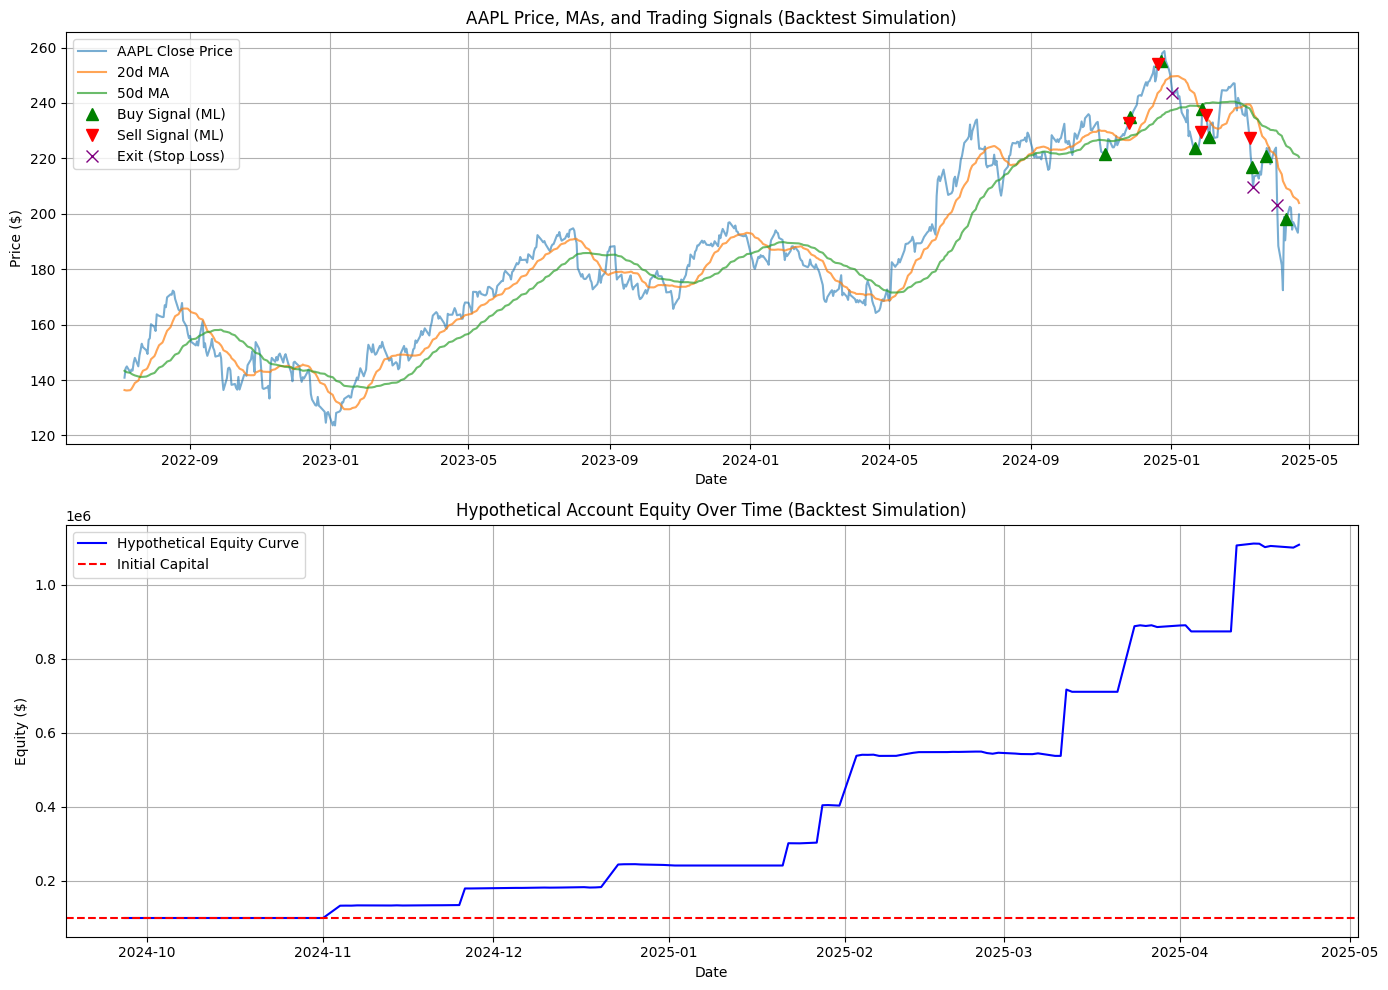


Plotting complete.


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report # Optional: uncomment for evaluation metrics
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time # To simulate delay if needed, not used in this script

# --- 1. Configuration and Parameters ---
ticker_symbol = "AAPL"
start_date = datetime.now() - timedelta(days=365 * 3) # Data for last 3 years
end_date = datetime.now()

# Strategy Parameters
short_window = 20 # Increased window for more data
long_window = 50  # Increased window for more data

# ML Parameters
test_size_split = 0.2 # 20% of data for simulating testing

# Illustrative Risk Management Parameters (Highly Simplified)
initial_capital = 100000.0 # Starting hypothetical capital
max_risk_per_trade_pct = 0.01 # Max 1% of capital per trade
stop_loss_percentage = 0.03 # 3% stop loss below entry price
max_open_positions = 5    # Maximum number of simultaneous hypothetical open trades
min_price_to_trade = 50.0 # Don't trade if price is below this

# --- 2. Download Historical Data ---
print(f"Attempting to download historical data for {ticker_symbol} from {start_date.date()} to {end_date.date()}...")

try:
    # auto_adjust=True means 'Close' column is already adjusted
    aapl_data = yf.download(ticker_symbol, start=start_date, end=end_date, auto_adjust=True)

    if aapl_data.empty:
        print(f"Error: Could not download data for {ticker_symbol}. Exiting.")
        exit() # Exit if data download fails

    print("Successfully downloaded data.")
    print(f"Total data points: {len(aapl_data)}")
    print("Columns available:", aapl_data.columns.tolist()) # Check available columns
    # We expect ['Open', 'High', 'Low', 'Close', 'Volume'] due to auto_adjust=True

except Exception as e:
    print(f"An error occurred during data download: {e}")
    print("Please check your internet connection and the ticker symbol.")
    exit() # Exit on download error


# --- 3. Feature Engineering ---
# Use 'Close' column for all price-based calculations
aapl_data['Price_Change'] = aapl_data['Close'].diff()
aapl_data['Short_MA'] = aapl_data['Close'].rolling(window=short_window).mean()
aapl_data['Long_MA'] = aapl_data['Close'].rolling(window=long_window).mean()
aapl_data['MA_Difference'] = aapl_data['Short_MA'] - aapl_data['Long_MA']
aapl_data['Volume_MA'] = aapl_data['Volume'].rolling(window=short_window).mean() # Add a volume feature

# --- Create Target Variable ---
# Predict if the Close price goes up tomorrow (1) or not (0)
aapl_data['Target'] = (aapl_data['Close'].shift(-1) > aapl_data['Close']).astype(int)

# --- 4. Data Preparation for ML ---
# Define features (X) and target (y)
# Use features that are available *before* the target outcome is known
features = ['Close', 'Price_Change', 'Short_MA', 'Long_MA', 'MA_Difference', 'Volume', 'Volume_MA']

# Drop rows with NaN values created by rolling windows and shift(-1)
# The number of NaNs depends on the largest window size (long_window)
aapl_data_cleaned = aapl_data.dropna().copy() # Use .copy() to avoid SettingWithCopyWarning

if len(aapl_data_cleaned) < 100: # Basic check if enough data remains
    print(f"Error: Not enough data remaining after cleaning ({len(aapl_data_cleaned)}). Adjust date range or windows. Exiting.")
    exit()

X = aapl_data_cleaned[features]
y = aapl_data_cleaned['Target']

# Split data into training and testing sets (simulating out-of-sample testing)
# shuffle=False is crucial for time series data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_split, shuffle=False)

print(f"\nData prepared for ML. Training on {len(X_train)} samples, testing on {len(X_test)} samples.")

# --- 5. Train the ML Model ---
print("\nTraining the ML model...")
model = LogisticRegression(max_iter=1000) # Increased max_iter for potential convergence
model.fit(X_train, y_train)
print("Model training complete.")

# Optional: Evaluate model performance (uncomment imports at top)
# y_pred = model.predict(X_test)
# print("\nML Model Evaluation on Test Set:")
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
# print("Classification Report:")
# print(classification_report(y_test, y_pred))


# --- 6. Generate Trading Signals based on ML Predictions ---
# We will generate signals for the *entire* cleaned dataset to simulate backtesting
# In real trading, you predict on the latest available data.
aapl_data_cleaned['Predicted_Target'] = model.predict(X)

# Generate a simple buy signal if the model predicts the price will go up (1)
# And a simple sell/exit signal if it predicts the price will not go up (0)
# This is a very basic strategy based solely on prediction. Real strategies are more complex.
aapl_data_cleaned['ML_Signal'] = np.where(aapl_data_cleaned['Predicted_Target'] == 1, 1, 0) # Use int 0/1

# Calculate position changes (1 for entry, -1 for exit)
# Fill NaN from diff() with 0 as no change occurred
aapl_data_cleaned['ML_Positions'] = aapl_data_cleaned['ML_Signal'].diff().fillna(0)


# --- 7. Illustrative Backtesting Simulation with Basic Risk Management ---

print("\n--- Starting Illustrative Backtesting Simulation ---")

# Initialize hypothetical account and position tracking
account_balance = initial_capital
current_capital = initial_capital # Capital available for trading (excludes value of open positions)
open_positions_count = 0
hypothetical_open_trades = {} # {trade_id: {'entry_price': price, 'num_shares': shares, 'stop_loss': price, 'take_profit': price}}
trade_counter = 0 # To generate unique trade IDs

# Lists to store data for visualization
equity_curve_dates = []
equity_curve_balances = []
buy_dates = []
buy_prices = []
ml_sell_dates = []
ml_sell_prices = []
sl_exit_dates = []
sl_exit_prices = []


# Iterate through the data points chronologically
# Start after the training period to simulate trading on unseen data
# We iterate through the *entire* cleaned data for the backtest visualization
# In a real scenario, you'd use a strict walk-forward testing approach
test_data_start_index = len(X_train) # Start backtest from where training ended

# Iterate through the cleaned DataFrame starting from the first day of the test set
for i in range(test_data_start_index, len(aapl_data_cleaned)):
    date = aapl_data_cleaned.index[i]
    current_price = aapl_data_cleaned['Close'].iloc[i].item() # Use .item() to get scalar
    ml_signal_change = aapl_data_cleaned['ML_Positions'].iloc[i].item() # Use .item()

    # --- Risk Management: Check for Stop Loss/Take Profit Triggers on Open Positions ---
    trades_to_close = []
    for trade_id, trade_info in hypothetical_open_trades.items():
        # Check if the current price triggered stop loss
        if current_price <= trade_info['stop_loss']:
            print(f"{date.date()}: Risk Alert: Stop Loss Triggered for {trade_id} (Price: {current_price:.2f}, Stop Loss: {trade_info['stop_loss']:.2f})")
            # Simulate closing position
            profit_loss = (current_price - trade_info['entry_price']) * trade_info['num_shares']
            # Update balances
            account_balance += (trade_info['entry_price'] * trade_info['num_shares']) + profit_loss # Return initial investment + P/L
            current_capital = account_balance - sum(t['entry_price'] * t['num_shares'] for t in hypothetical_open_trades.values()) # Recalculate available capital

            print(f"  - Closed {trade_id}: Realized P/L = {profit_loss:.2f}. New Balance = {account_balance:.2f}")
            trades_to_close.append(trade_id)

            # Record for plotting
            sl_exit_dates.append(date)
            sl_exit_prices.append(current_price)


        # Add Take Profit check here if implemented
        # elif current_price >= trade_info['take_profit']:
        #    ... simulate closing at take profit ...
        #    trades_to_close.append(trade_id)
        #    # Record for plotting (e.g., tp_exit_dates, tp_exit_prices)


    # Remove closed trades
    for trade_id in trades_to_close:
        if trade_id in hypothetical_open_trades:
            del hypothetical_open_trades[trade_id]
            open_positions_count = len(hypothetical_open_trades) # Update count based on actual open trades


    # --- Process New ML Signals ---
    if ml_signal_change == 1: # ML Model generated a Buy signal
        # --- Risk Check 1: Minimum Price ---
        if current_price < min_price_to_trade:
            print(f"{date.date()}: Buy Signal Ignored: Price ({current_price:.2f}) below minimum trade price ({min_price_to_trade:.2f})")
            # Record this rejected signal? Optional.
            continue # Skip this signal

        # --- Risk Check 2: Maximum Open Positions ---
        if open_positions_count >= max_open_positions:
            print(f"{date.date()}: Buy Signal Ignored: Max open positions ({max_open_positions}) reached")
            # Record this rejected signal? Optional.
            continue # Skip this signal

        # --- Risk Check 3 (Conceptual): Sufficient Capital for Risk ---
        # Calculate how many shares we can buy based on risk per trade
        # Price difference from entry to stop loss is the risk per share
        hypothetical_risk_per_share = current_price * stop_loss_percentage
        if hypothetical_risk_per_share <= 0: # Avoid division by zero or negative risk
             print(f"{date.date()}: Buy Signal Ignored: Invalid risk calculation ({hypothetical_risk_per_share:.4f})")
             continue

        # Maximum shares based on risk per trade
        max_shares_by_risk = (current_capital * max_risk_per_trade_pct) / hypothetical_risk_per_share

        # Also consider how many shares we can buy with available capital
        max_shares_by_capital = current_capital / current_price

        # Buy the minimum of the two to respect both risk and capital constraints
        num_shares_to_buy = min(max_shares_by_risk, max_shares_by_capital)

        if num_shares_to_buy < 1: # Don't buy fractional shares or zero
             print(f"{date.date()}: Buy Signal Ignored: Not enough capital for a single share at calculated risk.")
             continue

        # Round down to full shares
        num_shares_to_buy = int(num_shares_to_buy)

        # --- Execute Buy (Simulated) ---
        trade_counter += 1
        trade_id = f"BUY_{date.strftime('%Y%m%d')}_{trade_counter}"
        entry_price = current_price
        cost = entry_price * num_shares_to_buy
        hypothetical_stop_loss = entry_price * (1 - stop_loss_percentage)
        # hypothetical_take_profit = entry_price * (1 + take_profit_percentage) # If you add take profit

        # Update hypothetical state
        hypothetical_open_trades[trade_id] = {
            'entry_price': entry_price,
            'num_shares': num_shares_to_buy,
            'stop_loss': hypothetical_stop_loss,
            # 'take_profit': hypothetical_take_profit # If you add take profit
        }
        open_positions_count = len(hypothetical_open_trades)
        # current_capital is updated after closing positions, reflecting P/L
        # Account balance doesn't change until position is closed (realized P/L)


        print(f"{date.date()}: --- BUY SIGNAL ---")
        print(f"  - Price: {current_price:.2f}")
        print(f"  - Action: Hypothetically Bought {num_shares_to_buy} shares at {entry_price:.2f}")
        print(f"  - Hypothetical Cost: {cost:.2f}")
        print(f"  - Hypothetical Stop Loss: {hypothetical_stop_loss:.2f}")
        print(f"  - Open Positions: {open_positions_count}. Current Capital (available): {current_capital:.2f}. Account Balance (total equity): {account_balance:.2f}")

        # Record for plotting
        buy_dates.append(date)
        buy_prices.append(current_price)


    elif ml_signal_change == -1: # ML Model generated a Sell/Exit signal
        # This is simplistic. A real agent needs to decide *which* position to close.
        # For illustration, we'll just simulate closing *one* open position if any exist.
        if open_positions_count > 0:
            # Get the ID of an open trade (e.g., the oldest or most recent - simplistic!)
            trade_to_close_id = list(hypothetical_open_trades.keys())[0] # Just get the first one
            closed_trade = hypothetical_open_trades.pop(trade_to_close_id)
            open_positions_count = len(hypothetical_open_trades)

            entry_price = closed_trade['entry_price']
            num_shares = closed_trade['num_shares']
            profit_loss = (current_price - entry_price) * num_shares # P/L based on current price

            # Update balances
            account_balance += (entry_price * num_shares) + profit_loss # Return initial investment + P/L
            current_capital = account_balance - sum(t['entry_price'] * t['num_shares'] for t in hypothetical_open_trades.values()) # Recalculate available capital

            print(f"{date.date()}: --- SELL SIGNAL ---")
            print(f"  - Price: {current_price:.2f}")
            print(f"  - Action: Hypothetically Sold/Exited position {trade_to_close_id} (ML Signal)")
            print(f"  - Entry Price: {entry_price:.2f}, Exit Price: {current_price:.2f}, Shares: {num_shares}")
            print(f"  - Realized P/L = {profit_loss:.2f}. New Balance = {account_balance:.2f}")
            print(f"  - Open Positions: {open_positions_count}. Current Capital (available): {current_capital:.2f}")

            # Record for plotting
            ml_sell_dates.append(date)
            ml_sell_prices.append(current_price)

        # else: # No open positions to sell
            # print(f"{date.date()}: Sell Signal Ignored: No open positions.")

    # --- Record Equity Curve at the end of each step ---
    equity_curve_dates.append(date)
    # Calculate current total equity (account balance + market value of open positions)
    current_equity = account_balance # Start with the cash balance
    for trade_info in hypothetical_open_trades.values():
        # Add current market value of each open position
        current_equity += (current_price - trade_info['entry_price']) * trade_info['num_shares'] + (trade_info['entry_price'] * trade_info['num_shares']) # P/L + initial investment

    equity_curve_balances.append(current_equity)


# --- 8. Simulation Summary ---
print("\n--- End of Backtesting Simulation ---")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Account Balance: {account_balance:.2f}") # Note: This is the cash balance after closing trades
print(f"Final Total Equity: {equity_curve_balances[-1]:.2f}") # This includes value of any remaining open positions
print(f"Total Profit/Loss: {equity_curve_balances[-1] - initial_capital:.2f}")
print(f"Remaining hypothetical open positions: {open_positions_count}")
print("Note: This simulation is highly simplified and does not account for transaction costs, slippage, or real-time market dynamics.")


# --- 9. Plotting Results ---
print("\nGenerating plots...")

# Ensure the length of equity curve data matches
# (Should match the number of iterations in the simulation loop)
if len(equity_curve_dates) != len(equity_curve_balances):
     print("Warning: Equity curve data lengths do not match. Plotting might be inaccurate.")


# Plot 1: Price, Moving Averages, and Trade Signals
plt.figure(figsize=(14, 10)) # Increased figure size

plt.subplot(2, 1, 1) # Create subplot 1 (2 rows, 1 column, 1st plot)
plt.plot(aapl_data_cleaned['Close'], label='AAPL Close Price', alpha=0.6)
plt.plot(aapl_data_cleaned['Short_MA'], label=f'{short_window}d MA', alpha=0.7)
plt.plot(aapl_data_cleaned['Long_MA'], label=f'{long_window}d MA', alpha=0.7)

# Plot trade signals
plt.plot(buy_dates, buy_prices, '^', markersize=8, color='g', lw=0, label='Buy Signal (ML)')
plt.plot(ml_sell_dates, ml_sell_prices, 'v', markersize=8, color='r', lw=0, label='Sell Signal (ML)')
plt.plot(sl_exit_dates, sl_exit_prices, 'x', markersize=8, color='purple', lw=0, label='Exit (Stop Loss)') # Mark stop loss exits

plt.title(f'{ticker_symbol} Price, MAs, and Trading Signals (Backtest Simulation)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)


# Plot 2: Equity Curve
plt.subplot(2, 1, 2) # Create subplot 2
plt.plot(equity_curve_dates, equity_curve_balances, label='Hypothetical Equity Curve', color='blue')
plt.title('Hypothetical Account Equity Over Time (Backtest Simulation)')
plt.xlabel('Date')
plt.ylabel('Equity ($)')
plt.grid(True)
plt.axhline(initial_capital, color='red', linestyle='--', label='Initial Capital') # Add initial capital line
plt.legend()

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

print("\nPlotting complete.")

Attempting to download historical data for AAPL from 2022-04-24 to 2025-04-23...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data.
Total data points: 751

Engineering features...
Feature engineering complete.

Preparing data for ML...
Data prepared. Training on 561 samples, testing on 141 samples.

Training the ML model...
Model training complete.

Generating trading signals...
Signal generation complete.

--- Starting Illustrative Backtesting Simulation ---
2024-11-04: --- BUY SIGNAL --- Price: 221.52, Action: Hypothetically Bought 150 shares. SL: 214.88. Open: 1. Equity: 133228.37
2024-11-25: --- SELL SIGNAL --- Price: 232.61, Action: Hypothetically Sold/Exited BUY_20241104_1 (ML). P/L: 1663.77. Open: 0. Equity: 134892.14
2024-11-26: --- BUY SIGNAL --- Price: 234.80, Action: Hypothetically Bought 144 shares. SL: 227.76. Open: 1. Equity: 168703.60
2024-12-20: --- SELL SIGNAL --- Price: 254.21, Action: Hypothetically Sold/Exited BUY_20241126_2 (ML). P/L: 2794.85. Open: 0. Equity: 171498.45
2024-12-23: --- BUY SIGNAL --- Price: 254.99, Action: Hypothetically Bought 136 shares. SL: 247.

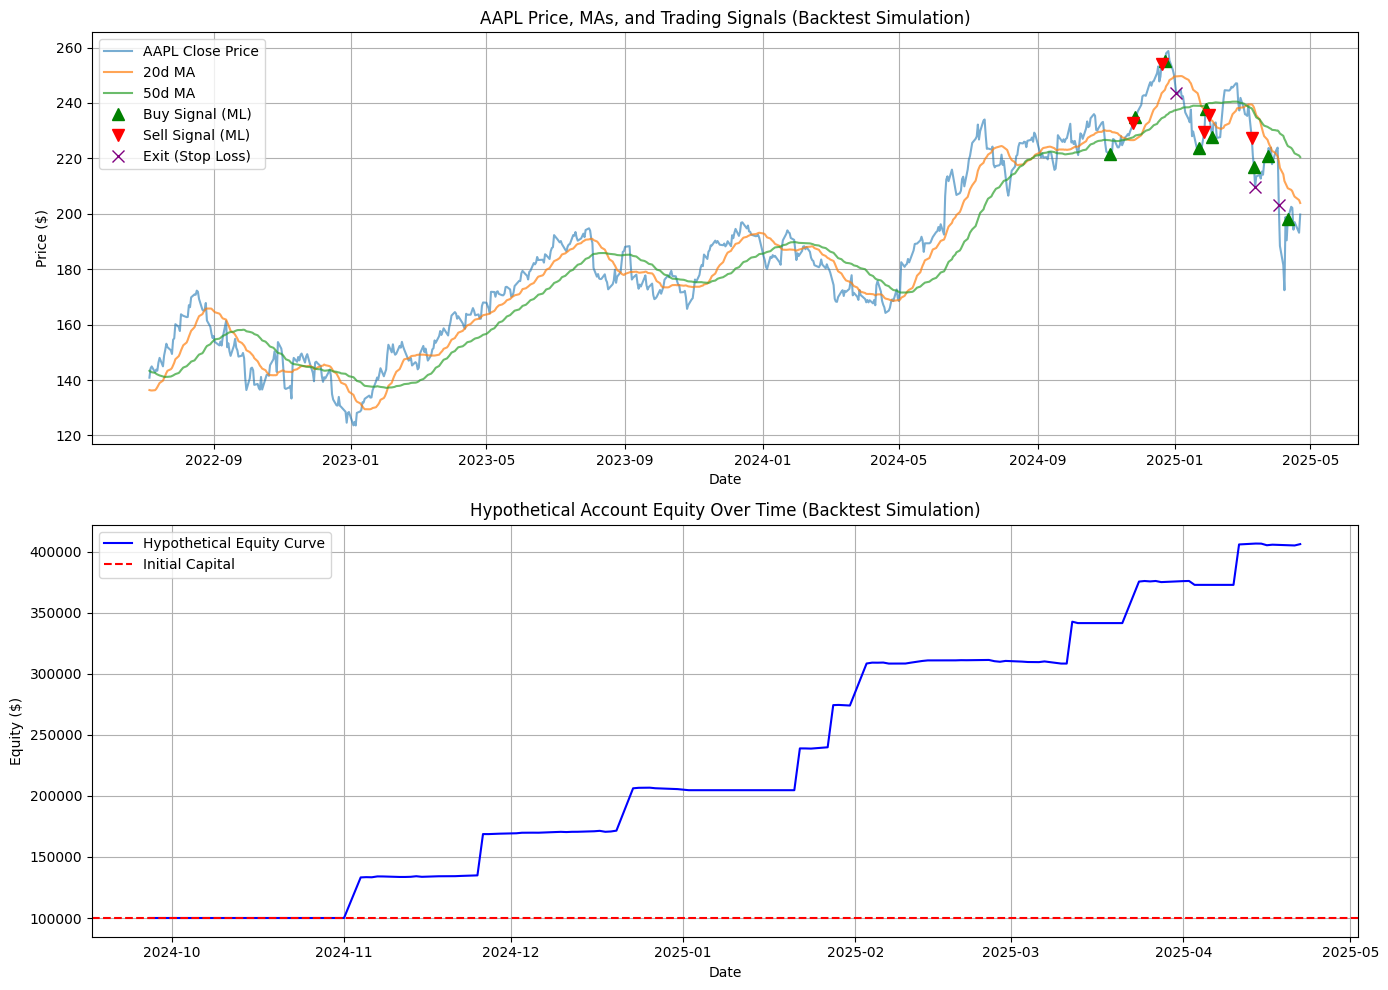

Plotting complete.


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report # Optional: uncomment for evaluation metrics
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- Define the TradingAgent Class ---
class TradingAgent:
    def __init__(self, ticker_symbol, start_date, end_date, initial_capital,
                 short_window, long_window, test_size_split,
                 max_risk_per_trade_pct, stop_loss_percentage, max_open_positions, min_price_to_trade):

        # Agent's Configuration
        self.ticker_symbol = ticker_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.initial_capital = float(initial_capital) # Ensure capital is float

        # Strategy/Feature Parameters
        self.short_window = short_window
        self.long_window = long_window
        self.test_size_split = test_size_split

        # Risk Management Parameters
        self.max_risk_per_trade_pct = max_risk_per_trade_pct
        self.stop_loss_percentage = stop_loss_percentage
        self.max_open_positions = max_open_positions
        self.min_price_to_trade = min_price_to_trade

        # Data Attributes
        self.data = None          # Raw downloaded data
        self.data_cleaned = None  # Data after feature engineering and cleaning
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None

        # Model Attribute
        self.model = None

        # Simulation State Attributes
        self.account_balance = self.initial_capital
        self.current_capital = self.initial_capital # Capital available for trading
        self.open_positions = {} # {trade_id: {'entry_price': price, 'num_shares': shares, 'stop_loss': price}}
        self.trade_counter = 0

        # Data for Plotting
        self.equity_curve_dates = []
        self.equity_curve_balances = []
        self.buy_dates = []
        self.buy_prices = []
        self.ml_sell_dates = []
        self.ml_sell_prices = []
        self.sl_exit_dates = []
        self.sl_exit_prices = []

    def download_data(self):
        """Downloads historical data for the specified ticker."""
        print(f"Attempting to download historical data for {self.ticker_symbol} from {self.start_date.date()} to {self.end_date.date()}...")
        try:
            self.data = yf.download(self.ticker_symbol, start=self.start_date, end=self.end_date, auto_adjust=True)
            if self.data.empty:
                print(f"Error: Could not download data for {self.ticker_symbol}.")
                self.data = None # Ensure data is None on failure
                return False
            print("Successfully downloaded data.")
            print(f"Total data points: {len(self.data)}")
            # We expect ['Open', 'High', 'Low', 'Close', 'Volume'] due to auto_adjust=True
            return True
        except Exception as e:
            print(f"An error occurred during data download: {e}")
            self.data = None # Ensure data is None on failure
            return False

    def engineer_features(self):
        """Creates technical indicators and other features."""
        if self.data is None:
            print("Error: No data downloaded. Cannot engineer features.")
            return False

        print("\nEngineering features...")
        # Use 'Close' column for all price-based calculations
        self.data['Price_Change'] = self.data['Close'].diff()
        self.data['Short_MA'] = self.data['Close'].rolling(window=self.short_window).mean()
        self.data['Long_MA'] = self.data['Close'].rolling(window=self.long_window).mean()
        self.data['MA_Difference'] = self.data['Short_MA'] - self.data['Long_MA']
        self.data['Volume_MA'] = self.data['Volume'].rolling(window=self.short_window).mean() # Add a volume feature

        # Create Target Variable
        self.data['Target'] = (self.data['Close'].shift(-1) > self.data['Close']).astype(int)

        # Drop rows with NaN values created by rolling windows and shift(-1)
        self.data_cleaned = self.data.dropna().copy()

        if len(self.data_cleaned) < 100:
            print(f"Error: Not enough data remaining after cleaning ({len(self.data_cleaned)}). Adjust date range or windows.")
            self.data_cleaned = None
            return False

        print("Feature engineering complete.")
        return True

    def prepare_data_for_ml(self):
        """Prepares data for ML training and testing."""
        if self.data_cleaned is None:
            print("Error: No cleaned data available. Cannot prepare for ML.")
            return False

        print("\nPreparing data for ML...")
        # Define features (X) and target (y)
        features = ['Close', 'Price_Change', 'Short_MA', 'Long_MA', 'MA_Difference', 'Volume', 'Volume_MA']

        # Ensure all required features exist after cleaning
        for feature in features:
            if feature not in self.data_cleaned.columns:
                print(f"Error: Required feature '{feature}' not found after cleaning.")
                return False


        X = self.data_cleaned[features]
        y = self.data_cleaned['Target']

        # Split data into training and testing sets (simulating out-of-sample testing)
        # shuffle=False is crucial for time series data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size_split, shuffle=False
        )

        print(f"Data prepared. Training on {len(self.X_train)} samples, testing on {len(self.X_test)} samples.")
        return True

    def train_model(self):
        """Trains the ML model."""
        if self.X_train is None or self.y_train is None:
            print("Error: Training data not prepared. Cannot train model.")
            return False

        print("\nTraining the ML model...")
        self.model = LogisticRegression(max_iter=1000) # Increased max_iter for potential convergence
        try:
            self.model.fit(self.X_train, self.y_train)
            print("Model training complete.")
            return True
        except Exception as e:
            print(f"An error occurred during model training: {e}")
            self.model = None
            return False

    def generate_signals(self):
        """Generates trading signals based on ML predictions."""
        if self.model is None or self.data_cleaned is None:
            print("Error: Model not trained or data not cleaned. Cannot generate signals.")
            return False

        print("\nGenerating trading signals...")
        # Predict on the *entire* cleaned dataset for backtesting simulation
        # In real trading, you predict on the latest available data.
        X_all = self.data_cleaned[['Close', 'Price_Change', 'Short_MA', 'Long_MA', 'MA_Difference', 'Volume', 'Volume_MA']] # Use features used for training
        self.data_cleaned['Predicted_Target'] = self.model.predict(X_all)

        # Generate a simple buy signal (1) or no signal (0)
        self.data_cleaned['ML_Signal'] = np.where(self.data_cleaned['Predicted_Target'] == 1, 1, 0)

        # Calculate position changes (1 for entry, -1 for exit)
        self.data_cleaned['ML_Positions'] = self.data_cleaned['ML_Signal'].diff().fillna(0)

        print("Signal generation complete.")
        # print(self.data_cleaned[['Close', 'ML_Signal', 'ML_Positions']].tail()) # Optional: check signals
        return True

    def run_backtest(self):
        """Runs the illustrative backtesting simulation with basic risk management."""
        if self.data_cleaned is None or 'ML_Positions' not in self.data_cleaned.columns:
            print("Error: Data not prepared or signals not generated. Cannot run backtest.")
            return False

        print("\n--- Starting Illustrative Backtesting Simulation ---")

        # Reset state for backtesting
        self.account_balance = self.initial_capital
        self.current_capital = self.initial_capital
        self.open_positions = {}
        self.trade_counter = 0
        self.equity_curve_dates = []
        self.equity_curve_balances = []
        self.buy_dates = []
        self.buy_prices = []
        self.ml_sell_dates = []
        self.ml_sell_prices = []
        self.sl_exit_dates = []
        self.sl_exit_prices = []

        # Determine the start index for the backtest (after the training period)
        test_data_start_index = len(self.X_train)

        # Iterate through the cleaned DataFrame starting from the first day of the test set
        for i in range(test_data_start_index, len(self.data_cleaned)):
            date = self.data_cleaned.index[i]
            current_price = self.data_cleaned['Close'].iloc[i].item()
            ml_signal_change = self.data_cleaned['ML_Positions'].iloc[i].item()

            # --- Risk Management: Check for Stop Loss Triggers on Open Positions ---
            trades_to_close_sl = []
            for trade_id, trade_info in list(self.open_positions.items()): # Iterate over a copy
                 if current_price <= trade_info['stop_loss']:
                    print(f"{date.date()}: Risk Alert: Stop Loss Triggered for {trade_id} (Price: {current_price:.2f}, Stop Loss: {trade_info['stop_loss']:.2f})")
                    # Simulate closing position
                    profit_loss = (current_price - trade_info['entry_price']) * trade_info['num_shares']
                    self.account_balance += (trade_info['entry_price'] * trade_info['num_shares']) + profit_loss
                    trades_to_close_sl.append(trade_id)

                    # Record for plotting
                    self.sl_exit_dates.append(date)
                    self.sl_exit_prices.append(current_price)


            # Remove closed trades
            for trade_id in trades_to_close_sl:
                 if trade_id in self.open_positions:
                     closed_trade = self.open_positions.pop(trade_id)
                     # Update current_capital based on realized P/L
                     self.current_capital += (closed_trade['entry_price'] * closed_trade['num_shares']) + (current_price - closed_trade['entry_price']) * closed_trade['num_shares']


            # --- Process New ML Signals ---
            if ml_signal_change == 1: # ML Model generated a Buy signal
                # --- Risk Check 1: Minimum Price ---
                if current_price < self.min_price_to_trade:
                    # print(f"{date.date()}: Buy Signal Ignored: Price ({current_price:.2f}) below minimum trade price ({self.min_price_to_trade:.2f})")
                    continue

                # --- Risk Check 2: Maximum Open Positions ---
                if len(self.open_positions) >= self.max_open_positions:
                    # print(f"{date.date()}: Buy Signal Ignored: Max open positions ({self.max_open_positions}) reached")
                    continue

                # --- Risk Check 3 (Conceptual): Sufficient Capital for Risk ---
                hypothetical_risk_per_share = current_price * self.stop_loss_percentage
                if hypothetical_risk_per_share <= 0:
                     # print(f"{date.date()}: Buy Signal Ignored: Invalid risk calculation ({hypothetical_risk_per_share:.4f})")
                     continue

                max_shares_by_risk = (self.current_capital * self.max_risk_per_trade_pct) / hypothetical_risk_per_share
                max_shares_by_capital = self.current_capital / current_price

                # Ensure we buy at least 1 share if conditions met
                num_shares_to_buy = int(min(max_shares_by_risk, max_shares_by_capital))
                if num_shares_to_buy < 1 and (max_shares_by_risk >= 1 or max_shares_by_capital >= 1):
                     num_shares_to_buy = 1 # Buy at least one share if risk/capital allows for at least one

                if num_shares_to_buy < 1:
                     # print(f"{date.date()}: Buy Signal Ignored: Not enough capital for a single share at calculated risk.")
                     continue


                # --- Execute Buy (Simulated) ---
                self.trade_counter += 1
                trade_id = f"BUY_{date.strftime('%Y%m%d')}_{self.trade_counter}"
                entry_price = current_price
                cost = entry_price * num_shares_to_buy
                hypothetical_stop_loss = entry_price * (1 - self.stop_loss_percentage)

                self.open_positions[trade_id] = {
                    'entry_price': entry_price,
                    'num_shares': num_shares_to_buy,
                    'stop_loss': hypothetical_stop_loss,
                }
                self.current_capital -= cost # Decrease available capital by cost

                print(f"{date.date()}: --- BUY SIGNAL --- Price: {current_price:.2f}, Action: Hypothetically Bought {num_shares_to_buy} shares. SL: {hypothetical_stop_loss:.2f}. Open: {len(self.open_positions)}. Equity: {self._calculate_current_equity(current_price):.2f}")

                # Record for plotting
                self.buy_dates.append(date)
                self.buy_prices.append(current_price)


            elif ml_signal_change == -1: # ML Model generated a Sell/Exit signal
                # Simulate closing *one* open position if any exist (simplistic!)
                if len(self.open_positions) > 0:
                    trade_to_close_id = list(self.open_positions.keys())[0] # Get the first one
                    closed_trade = self.open_positions.pop(trade_to_close_id)

                    entry_price = closed_trade['entry_price']
                    num_shares = closed_trade['num_shares']
                    profit_loss = (current_price - entry_price) * num_shares

                    self.account_balance += (entry_price * num_shares) + profit_loss
                    # Update current_capital based on realized P/L
                    self.current_capital += (closed_trade['entry_price'] * closed_trade['num_shares']) + profit_loss


                    print(f"{date.date()}: --- SELL SIGNAL --- Price: {current_price:.2f}, Action: Hypothetically Sold/Exited {trade_to_close_id} (ML). P/L: {profit_loss:.2f}. Open: {len(self.open_positions)}. Equity: {self._calculate_current_equity(current_price):.2f}")

                    # Record for plotting
                    self.ml_sell_dates.append(date)
                    self.ml_sell_prices.append(current_price)


            # --- Record Equity Curve at the end of each step ---
            self.equity_curve_dates.append(date)
            self.equity_curve_balances.append(self._calculate_current_equity(current_price))


        print("\n--- End of Illustrative Backtesting Simulation ---")
        print(f"Initial Capital: {self.initial_capital:.2f}")
        print(f"Final Account Balance (Cash): {self.account_balance:.2f}")
        final_equity = self._calculate_current_equity(current_price) if self.equity_curve_balances else self.initial_capital
        print(f"Final Total Equity: {final_equity:.2f}")
        print(f"Total Profit/Loss: {final_equity - self.initial_capital:.2f}")
        print(f"Remaining hypothetical open positions: {len(self.open_positions)}")
        print("Note: This simulation is highly simplified.")

    def _calculate_current_equity(self, current_price):
        """Calculates the total hypothetical account equity."""
        current_equity = self.account_balance # Start with the cash balance
        for trade_info in self.open_positions.values():
            # Add current market value of each open position
            # Ensure current_price is treated as a scalar for calculation
             current_equity += trade_info['num_shares'] * float(current_price) # Explicitly cast current_price

        return current_equity


    def plot_results(self):
        """Generates plots for price/signals and equity curve."""
        # Check if there is data to plot after cleaning and backtesting
        if self.data_cleaned is not None and not self.data_cleaned.empty and self.equity_curve_dates:
            print("\nGenerating plots...")
            plt.figure(figsize=(14, 10))

            # Plot 1: Price, Moving Averages, and Trade Signals
            plt.subplot(2, 1, 1)
            # Ensure the index for plotting matches the data
            plt.plot(self.data_cleaned.index, self.data_cleaned['Close'], label='AAPL Close Price', alpha=0.6)
            plt.plot(self.data_cleaned.index, self.data_cleaned['Short_MA'], label=f'{self.short_window}d MA', alpha=0.7)
            plt.plot(self.data_cleaned.index, self.data_cleaned['Long_MA'], label=f'{self.long_window}d MA', alpha=0.7)

            # Plot trade signals - filter to only include dates from the backtest period
            # The equity curve dates already represent the backtest period simulation ran over
            backtest_start_date = self.equity_curve_dates[0] if self.equity_curve_dates else self.data_cleaned.index[0]


            buy_dates_plot = [d for d in self.buy_dates if d >= backtest_start_date]
            buy_prices_plot = [self.data_cleaned.loc[d, 'Close'].item() for d in buy_dates_plot if d in self.data_cleaned.index]

            ml_sell_dates_plot = [d for d in self.ml_sell_dates if d >= backtest_start_date]
            ml_sell_prices_plot = [self.data_cleaned.loc[d, 'Close'].item() for d in ml_sell_dates_plot if d in self.data_cleaned.index]

            sl_exit_dates_plot = [d for d in self.sl_exit_dates if d >= backtest_start_date]
            sl_exit_prices_plot = [self.data_cleaned.loc[d, 'Close'].item() for d in sl_exit_dates_plot if d in self.data_cleaned.index]

            # Only attempt to plot if there are points to plot
            if buy_dates_plot:
                plt.plot(buy_dates_plot, buy_prices_plot, '^', markersize=8, color='g', lw=0, label='Buy Signal (ML)')
            if ml_sell_dates_plot:
                 plt.plot(ml_sell_dates_plot, ml_sell_prices_plot, 'v', markersize=8, color='r', lw=0, label='Sell Signal (ML)')
            if sl_exit_dates_plot:
                 plt.plot(sl_exit_dates_plot, sl_exit_prices_plot, 'x', markersize=8, color='purple', lw=0, label='Exit (Stop Loss)')


            plt.title(f'{self.ticker_symbol} Price, MAs, and Trading Signals (Backtest Simulation)')
            plt.xlabel('Date')
            plt.ylabel('Price ($)')
            plt.legend()
            plt.grid(True)


            # Plot 2: Equity Curve
            plt.subplot(2, 1, 2)
            plt.plot(self.equity_curve_dates, self.equity_curve_balances, label='Hypothetical Equity Curve', color='blue')
            plt.title('Hypothetical Account Equity Over Time (Backtest Simulation)')
            plt.xlabel('Date')
            plt.ylabel('Equity ($)')
            plt.grid(True)
            plt.axhline(self.initial_capital, color='red', linestyle='--', label='Initial Capital')
            plt.legend()

            plt.tight_layout()
            plt.show()

            print("Plotting complete.")
        else:
            print("\nNot enough data or no simulation results to plot.")


# --- Main Execution Block ---
if __name__ == "__main__":
    # --- Configure the Agent ---
    agent_config = {
        "ticker_symbol": "AAPL",
        "start_date": datetime.now() - timedelta(days=365 * 3), # 3 years of data
        "end_date": datetime.now(),
        "initial_capital": 100000.0,
        "short_window": 20,
        "long_window": 50,
        "test_size_split": 0.2,
        "max_risk_per_trade_pct": 0.01,
        "stop_loss_percentage": 0.03,
        "max_open_positions": 5,
        "min_price_to_trade": 50.0,
    }

    # Create an instance of the Trading Agent
    trading_agent = TradingAgent(**agent_config)

    # Run the agent's process
    if trading_agent.download_data():
        if trading_agent.engineer_features():
            if trading_agent.prepare_data_for_ml():
                if trading_agent.train_model():
                    if trading_agent.generate_signals():
                        trading_agent.run_backtest()
                        trading_agent.plot_results()
                    else:
                        print("Failed to generate signals.")
                else:
                    print("Failed to train model.")
            else:
                print("Failed to prepare data for ML.")
        else:
            print("Failed to engineer features.")
    else:
        print("Failed to download data.")